# Matemáticas aplicadas. Parcial 2

#### Samuel Acosta Aristizábal - 1000900513
#### Manuela Caro Villada - 1000124254
#### Jeronimo Velasquez Escobar - 1000116682

In [1]:
## Se inicialializa el programa y se importan las librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Ejercicio Numero 1

In [ ]:
## Se cargan los datos del archivo CSV

data = pd.read_csv('data/datos_ejercicio1.csv')

## Cargar los datos como una matriz con numpy
X = data.to_numpy()

## Creacion de la matriz de similitud
def pairwise_distances(X):
    n = X.shape[0]
    D = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            D[i,j] = np.linalg.norm(X[i] - X[j])

    return D
def build_similarity(X, kNN=10, epsilon=1e-5):
    n = X.shape[0]
    distances = pairwise_distances(X)

    S = np.zeros((n,n))

    for i in range(n):
        idx_sorted = np.argsort(distances[i])
        neighbors = idx_sorted[1:kNN+1]  # ignorar él mismo

        for j in neighbors:
            S[i,j] = 1 / (distances[i,j] + epsilon)

    # hacerla simétrica
    S = (S + S.T) / 2
    return S
def build_laplacian(S):
    D = np.diag(S.sum(axis=1))
    L = D - S
    return L

S = build_similarity(X, kNN=10)
L = build_laplacian(S)
## Calcular los autovectores y autovalores del Laplaciano
eigenvalues, eigenvectors = np.linalg.eigh(L)
## Ordenar los autovectores y autovalores de menor a mayor
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

Text(0, 0.5, 'Valor propio')

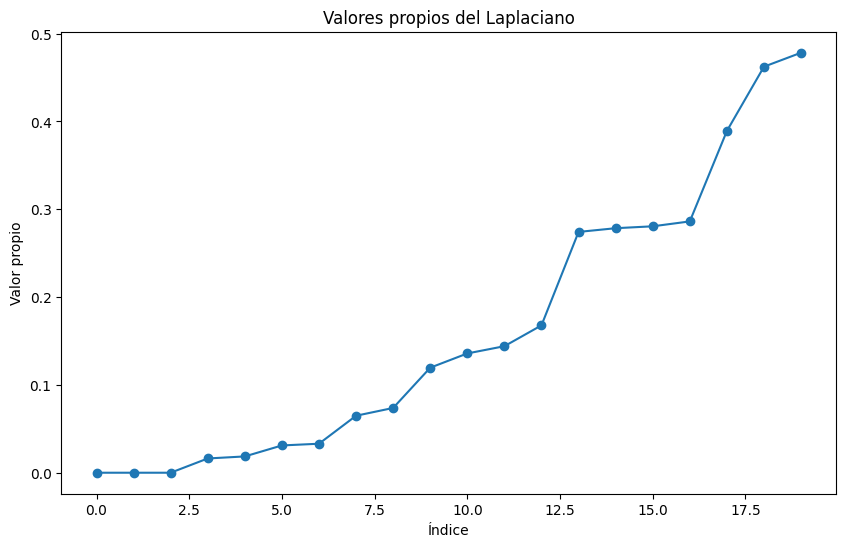

In [ ]:
# Se grafican los vlores propios para visualizar el codo
plt.figure(figsize=(10,6))
plt.plot(eigenvalues[:20], marker='o')
plt.title('Valores propios del Laplaciano')
plt.xlabel('Índice')
plt.ylabel('Valor propio')

In [ ]:
## Basados en la grafica anterior nos quedamos con k = 13, puesto que es el punto donde se observa un cambio mas significativo en los valores propios
## Aunque 17 esta en consideracion, se opta por 13 para evitar un posible sobreajuste
k = 13

def kmeans(X, k, max_iters=100):
    n, d = X.shape

    # Inicialización aleatoria
    centroids = X[np.random.choice(n, k, replace=False)]

    for _ in range(max_iters):
        # Asignación
        labels = np.zeros(n)
        for i in range(n):
            distances = [np.linalg.norm(X[i] - c) for c in centroids]
            labels[i] = np.argmin(distances)

        # Actualización
        new_centroids = np.array([
            X[labels == j].mean(axis=0) if len(X[labels == j]) > 0 else centroids[j]
            for j in range(k)
        ])

        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return labels

# Se seleccionan los k autovectores correspondientes a los k menores autovalores
X_k = eigenvectors[:, :k]
# Se aplica k-means sobre los autovectores seleccionados
labels = kmeans(X_k, k)
labels_original = kmeans(X, k)

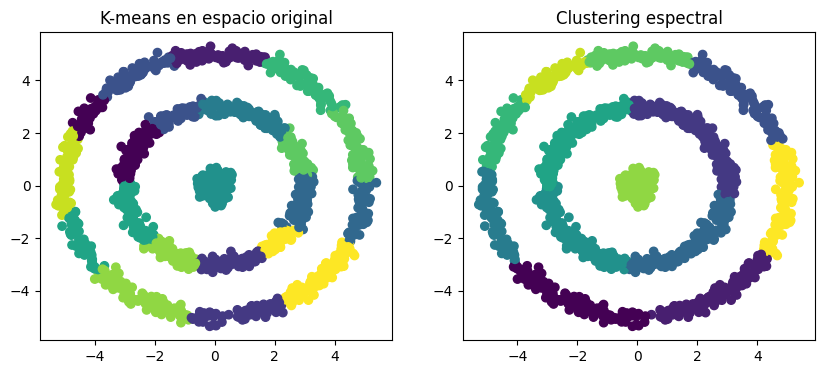

In [ ]:
## Comparamos ambos resultados graficamente para visualizar las diferencias entre el clustering en el espacio original y el clustering espectral
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=labels_original)
plt.title("K-means en espacio original")

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=labels)
plt.title("Clustering espectral")

plt.show()

In [ ]:
## Creacion de la matriz de similitud con kernel gaussiano
def build_similarity_gaussian(X, kNN=10, sigma=1.0):
    n = X.shape[0]
    distances = pairwise_distances(X)
    S = np.zeros((n,n))

    for i in range(n):
        idx_sorted = np.argsort(distances[i])
        neighbors = idx_sorted[1:kNN+1]

        for j in neighbors:
            S[i,j] = np.exp(-(distances[i,j]**2)/(2*sigma**2))

    S = (S + S.T)/2
    return S

In [ ]:
## Repetimos pipelines con la nueva matriz de similitud
S_gaussian = build_similarity_gaussian(X, kNN=10, sigma=1.0)
L_gaussian = build_laplacian(S_gaussian)
eigenvalues_gaussian, eigenvectors_gaussian = np.linalg.eigh(L_gaussian)
idx_gaussian = np.argsort(eigenvalues_gaussian)
eigenvalues_gaussian = eigenvalues_gaussian[idx_gaussian]
eigenvectors_gaussian = eigenvectors_gaussian[:, idx_gaussian]


Text(0, 0.5, 'Valor propio')

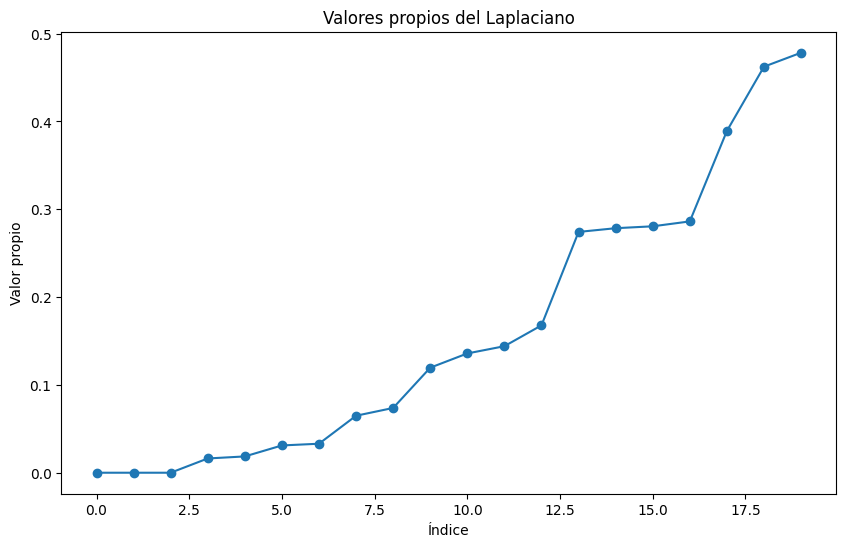

In [ ]:
# Se grafican los vlores propios para visualizar el codo
plt.figure(figsize=(10,6))
plt.plot(eigenvalues[:20], marker='o')
plt.title('Valores propios del Laplaciano')
plt.xlabel('Índice')
plt.ylabel('Valor propio')

In [ ]:
gaussian_k = 13
X_k_gaussian = eigenvectors_gaussian[:, :gaussian_k]
labels_gaussian = kmeans(X_k_gaussian, gaussian_k)


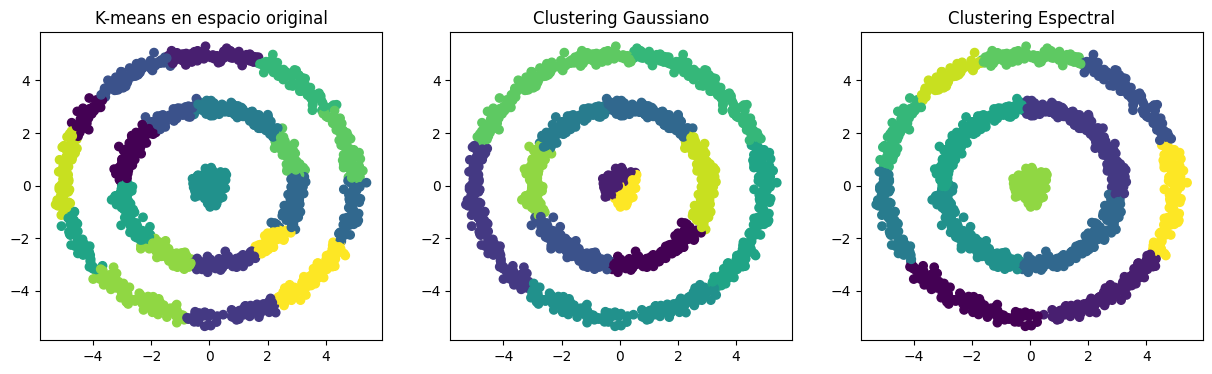

In [ ]:
## Comparamos ambos resultados graficamente para visualizar las diferencias entre el clustering en el espacio original y el clustering espectral
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(X[:,0], X[:,1], c=labels_original)
plt.title("K-means en espacio original")

plt.subplot(1,3,2)
plt.scatter(X[:,0], X[:,1], c=labels_gaussian)
plt.title("Clustering Gaussiano")

plt.subplot(1,3,3)
plt.scatter(X[:,0], X[:,1], c=labels)
plt.title("Clustering Espectral")

plt.show()

### Resultados obtenidos tras realizar el punto numero 1

- El método k-means en el espacio original falla debido a que los clusters no presentan forma convexa. El uso de una matriz de similitud basada en un kernel gaussiano mejora la preservación de la estructura local. Sin embargo, el método espectral logra capturar adecuadamente la estructura topológica del dataset, separando correctamente los anillos concéntricos al proyectar los datos en el subespacio generado por los eigenvectores asociados a los menores eigenvalores del Laplaciano.

# Ejercicio 2

In [ ]:
!pip install keras -q

In [ ]:
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.random.seed(42)

# ── Cargar MNIST sin TensorFlow ──────────────────────────────────────────────
# Opción 1: keras standalone
try:
    from keras.datasets import mnist
    (X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()
    print('✅ MNIST cargado con keras standalone')

# Opción 2: torchvision
except Exception:
    try:
        from torchvision.datasets import MNIST
        ds_train = MNIST(root='./data', train=True,  download=True)
        ds_test  = MNIST(root='./data', train=False, download=True)
        X_train_raw = ds_train.data.numpy()
        y_train_raw = ds_train.targets.numpy()
        X_test_raw  = ds_test.data.numpy()
        y_test_raw  = ds_test.targets.numpy()
        print('✅ MNIST cargado con torchvision')

    # Opción 3: descarga directa (sin librerías ML)
    except Exception:
        import urllib.request, gzip, os
        def _load(url, offset):
            fname = url.split('/')[-1]
            if not os.path.exists(fname):
                urllib.request.urlretrieve(url, fname)
            with gzip.open(fname, 'rb') as f:
                return np.frombuffer(f.read(), dtype=np.uint8, offset=offset)
        base = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
        X_train_raw = _load(base+'train-images-idx3-ubyte.gz', 16).reshape(-1,28,28)
        y_train_raw = _load(base+'train-labels-idx1-ubyte.gz',  8)
        X_test_raw  = _load(base+'t10k-images-idx3-ubyte.gz',  16).reshape(-1,28,28)
        y_test_raw  = _load(base+'t10k-labels-idx1-ubyte.gz',   8)
        print('✅ MNIST cargado con descarga directa')

print(f'Entrenamiento: {X_train_raw.shape} | Prueba: {X_test_raw.shape}')
print(f'Rango de píxeles: [{X_train_raw.min()}, {X_train_raw.max()}]')

✅ MNIST cargado con descarga directa
Entrenamiento: (60000, 28, 28) | Prueba: (10000, 28, 28)
Rango de píxeles: [0, 255]


## 1. Preprocesamiento

Para cada imagen:
1. **Recortar** las filas/columnas de fondo (píxeles < umbral)
2. **Reescalar** a 16×16 píxeles
3. **Aplanar** a vector de longitud 256

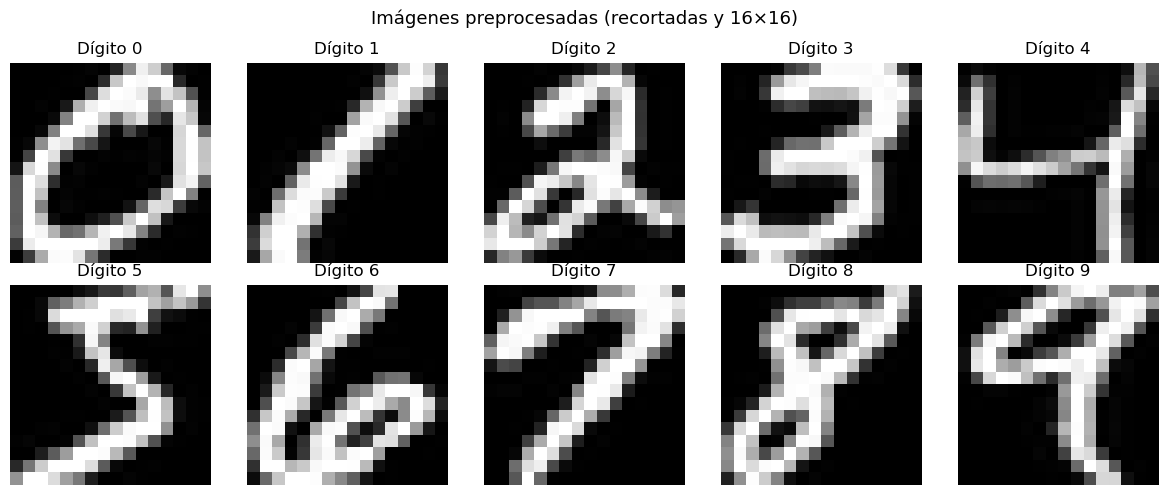

In [ ]:
def crop_and_resize(img, size=(16, 16), threshold=10):
    """
    Recorta filas/columnas de fondo y reescala la imagen a `size`.
    Retorna np.array de shape `size`, valores en [0, 1].
    """
    rows = np.any(img > threshold, axis=1)
    cols = np.any(img > threshold, axis=0)

    if not rows.any() or not cols.any():
        return np.zeros(size)

    r_min, r_max = np.where(rows)[0][[0, -1]]
    c_min, c_max = np.where(cols)[0][[0, -1]]

    cropped = img[r_min:r_max+1, c_min:c_max+1]
    pil_img = Image.fromarray(cropped.astype(np.uint8))
    resized = pil_img.resize(size[::-1], Image.LANCZOS)  # PIL usa (W, H)
    return np.array(resized, dtype=float) / 255.0


def preprocess_images(images):
    """Aplica crop_and_resize a un arreglo de imágenes → matriz (n, 256)."""
    return np.array([crop_and_resize(img).flatten() for img in images])


# ── Demostración visual ──────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for d in range(10):
    idx  = np.where(y_train_raw == d)[0][0]
    proc = crop_and_resize(X_train_raw[idx])
    ax   = axes[d // 5, d % 5]
    ax.imshow(proc, cmap='gray')
    ax.set_title(f'Dígito {d}')
    ax.axis('off')
plt.suptitle('Imágenes preprocesadas (recortadas y 16×16)', fontsize=13)
plt.tight_layout()
plt.show()

## 2. Construcción de bases ortonormales $B_d$

**Interpretación:** $U_d = \text{span}(B_d)$ resume la variabilidad visual del dígito $d$. Cada vector de la base es una "dirección de variación" del dígito, análogo a los *eigenfaces*.

In [ ]:
def build_orthonormal_bases(X_train, y_train, k, digits=range(10)):
    """
    Construye la base ortonormal B_d para cada dígito d via SVD.
    Retorna dict {d: B_d} donde B_d tiene forma (256, r).
    """
    bases = {}
    for d in digits:
        idx    = np.where(y_train == d)[0]
        chosen = np.random.choice(idx, size=min(k, len(idx)), replace=False)
        vecs   = preprocess_images(X_train[chosen])  # (k, 256)
        M_d    = vecs.T                               # (256, k)

        U, S, _ = np.linalg.svd(M_d, full_matrices=False)

        # Conservar solo vectores con valor singular significativo
        tol      = 1e-6 * S[0] if S[0] > 0 else 1e-10
        r        = np.sum(S > tol)
        bases[d] = U[:, :r]  # (256, r)
    return bases


# ── Demo con k=50 ────────────────────────────────────────────────────────────
k_demo     = 50
bases_demo = build_orthonormal_bases(X_train_raw, y_train_raw, k=k_demo)

print('Dimensiones de las bases ortonormales B_d (256 × r):')
for d, B in bases_demo.items():
    print(f'  Dígito {d}: forma {B.shape}  → rango efectivo = {B.shape[1]}')

Dimensiones de las bases ortonormales B_d (256 × r):
  Dígito 0: forma (256, 50)  → rango efectivo = 50
  Dígito 1: forma (256, 50)  → rango efectivo = 50
  Dígito 2: forma (256, 50)  → rango efectivo = 50
  Dígito 3: forma (256, 50)  → rango efectivo = 50
  Dígito 4: forma (256, 50)  → rango efectivo = 50
  Dígito 5: forma (256, 50)  → rango efectivo = 50
  Dígito 6: forma (256, 50)  → rango efectivo = 50
  Dígito 7: forma (256, 50)  → rango efectivo = 50
  Dígito 8: forma (256, 50)  → rango efectivo = 50
  Dígito 9: forma (256, 50)  → rango efectivo = 50


### Visualización de los primeros vectores de la base

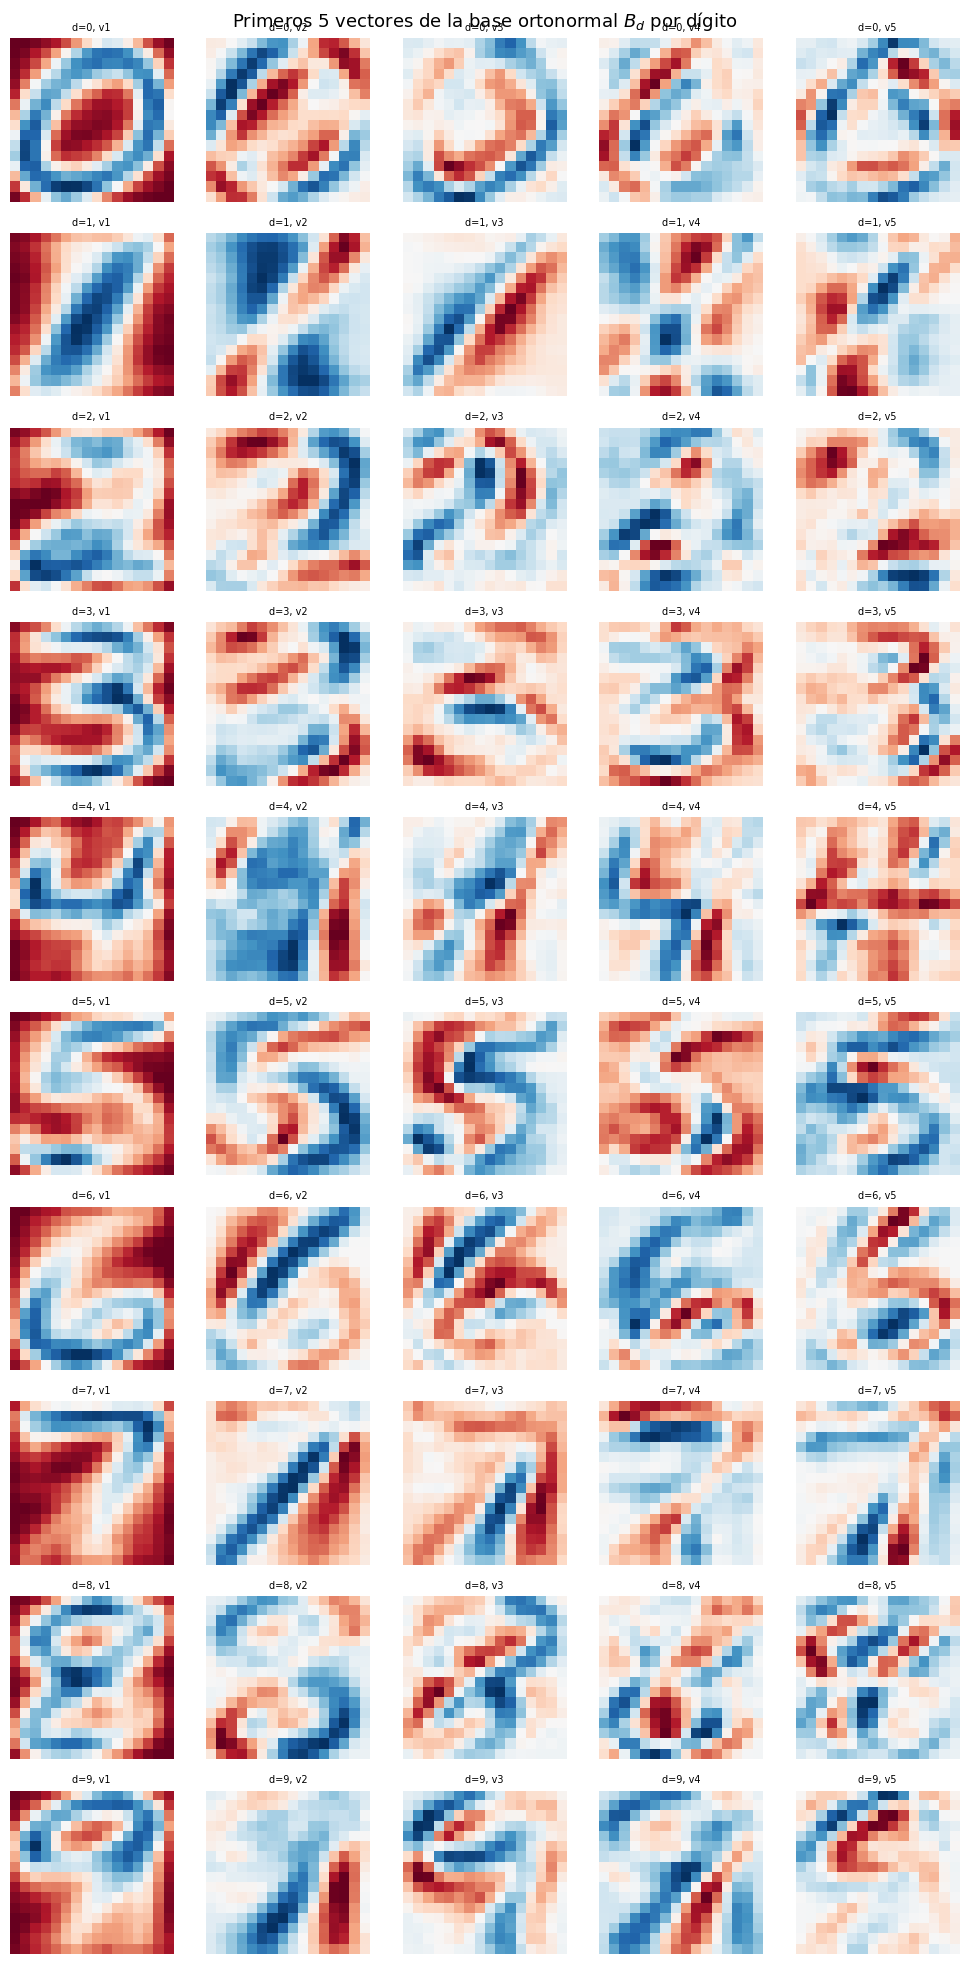

In [ ]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))

for d in range(10):
    B = bases_demo[d]
    for j in range(5):
        ax = axes[d, j]
        if j < B.shape[1]:
            ax.imshow(B[:, j].reshape(16, 16), cmap='RdBu_r')
            ax.set_title(f'd={d}, v{j+1}', fontsize=7)
        ax.axis('off')

plt.suptitle('Primeros 5 vectores de la base ortonormal $B_d$ por dígito', fontsize=13)
plt.tight_layout()
plt.show()

## 3. Clasificación por proyección ortogonal

La **proyección ortogonal** de $q$ sobre el subespacio $U_d$ es:

$$p_d = B_d B_d^T q$$

La distancia al subespacio es $\text{dist}(q, d) = \|q - p_d\|$, y la predicción:

$$\hat{d} = \arg\min_d \, \text{dist}(q, d)$$

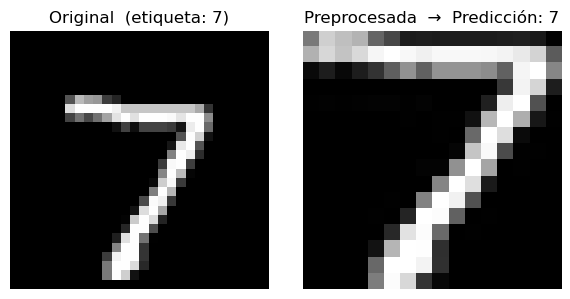

In [ ]:
def project_onto_subspace(q, B):
    """Proyección ortogonal de q sobre el subespacio generado por columnas de B."""
    return B @ (B.T @ q)


def classify(q, bases):
    """Retorna el dígito con menor distancia de proyección."""
    best_digit, min_dist = -1, np.inf
    for d, B in bases.items():
        dist = np.linalg.norm(q - project_onto_subspace(q, B))
        if dist < min_dist:
            min_dist, best_digit = dist, d
    return best_digit


# ── Ejemplo con una imagen de prueba ────────────────────────────────────────
test_idx = 0
q_raw    = X_test_raw[test_idx]
q        = crop_and_resize(q_raw).flatten()
pred     = classify(q, bases_demo)
true     = y_test_raw[test_idx]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(q_raw, cmap='gray')
ax[0].set_title(f'Original  (etiqueta: {true})')
ax[0].axis('off')
ax[1].imshow(q.reshape(16, 16), cmap='gray')
ax[1].set_title(f'Preprocesada  →  Predicción: {pred}')
ax[1].axis('off')
plt.tight_layout()
plt.show()

## 4. Evaluación del clasificador

In [ ]:
def evaluate_classifier(bases, X_test, y_test, max_test=1000):
    """Evalúa el clasificador sobre max_test imágenes. Retorna accuracy."""
    n       = min(max_test, len(X_test))
    indices = np.random.choice(len(X_test), size=n, replace=False)
    correct = sum(
        classify(crop_and_resize(X_test[i]).flatten(), bases) == y_test[i]
        for i in indices
    )
    return correct / n


acc_demo = evaluate_classifier(bases_demo, X_test_raw, y_test_raw, max_test=500)
print(f'Accuracy con k={k_demo}: {acc_demo*100:.2f}%')

Accuracy con k=50: 92.20%


### 4.1 Precisión en función de $k$

k=   5  →  accuracy = 68.60%
k=  10  →  accuracy = 82.00%
k=  20  →  accuracy = 85.40%
k=  50  →  accuracy = 90.60%
k= 100  →  accuracy = 91.20%
k= 200  →  accuracy = 85.20%
k= 500  →  accuracy = 56.60%


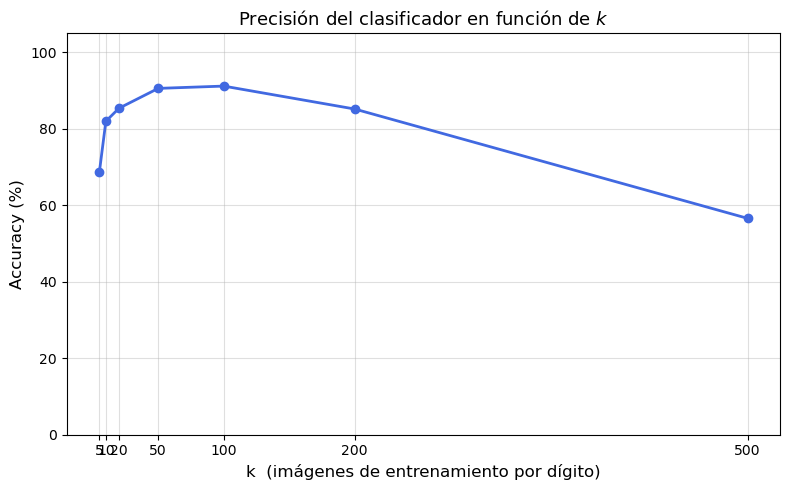

In [ ]:
k_values   = [5, 10, 20, 50, 100, 200, 500]
accuracies = []
MAX_TEST   = 500

for k in k_values:
    bases_k = build_orthonormal_bases(X_train_raw, y_train_raw, k=k)
    acc     = evaluate_classifier(bases_k, X_test_raw, y_test_raw, max_test=MAX_TEST)
    accuracies.append(acc)
    print(f'k={k:>4}  →  accuracy = {acc*100:.2f}%')

# ── Gráfico ──────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(k_values, [a * 100 for a in accuracies],
         marker='o', linewidth=2, color='royalblue')
plt.xlabel('k  (imágenes de entrenamiento por dígito)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Precisión del clasificador en función de $k$', fontsize=13)
plt.grid(True, alpha=0.4)
plt.xticks(k_values)
plt.ylim(0, 105)
plt.tight_layout()
plt.show()

### 4.2 Matriz de confusión (mejor $k$)

Mejor k encontrado: 100


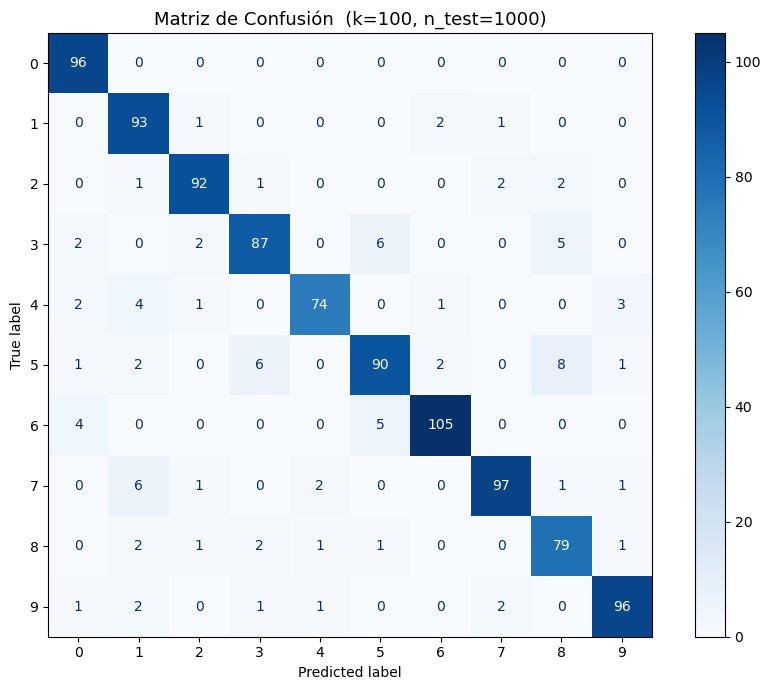

Accuracy global (k=100): 90.90%


In [ ]:
best_k     = k_values[int(np.argmax(accuracies))]
bases_best = build_orthonormal_bases(X_train_raw, y_train_raw, k=best_k)
print(f'Mejor k encontrado: {best_k}')

n_eval   = 1000
indices  = np.random.choice(len(X_test_raw), size=n_eval, replace=False)
y_true_l, y_pred_l = [], []

for i in indices:
    q = crop_and_resize(X_test_raw[i]).flatten()
    y_pred_l.append(classify(q, bases_best))
    y_true_l.append(y_test_raw[i])

cm  = confusion_matrix(y_true_l, y_pred_l)
fig, ax = plt.subplots(figsize=(9, 7))
ConfusionMatrixDisplay(cm, display_labels=list(range(10))).plot(
    ax=ax, colorbar=True, cmap='Blues'
)
ax.set_title(f'Matriz de Confusión  (k={best_k}, n_test={n_eval})', fontsize=13)
plt.tight_layout()
plt.show()

overall = np.mean(np.array(y_true_l) == np.array(y_pred_l))
print(f'Accuracy global (k={best_k}): {overall*100:.2f}%')

### 4.3 Visualización de proyecciones sobre cada subespacio

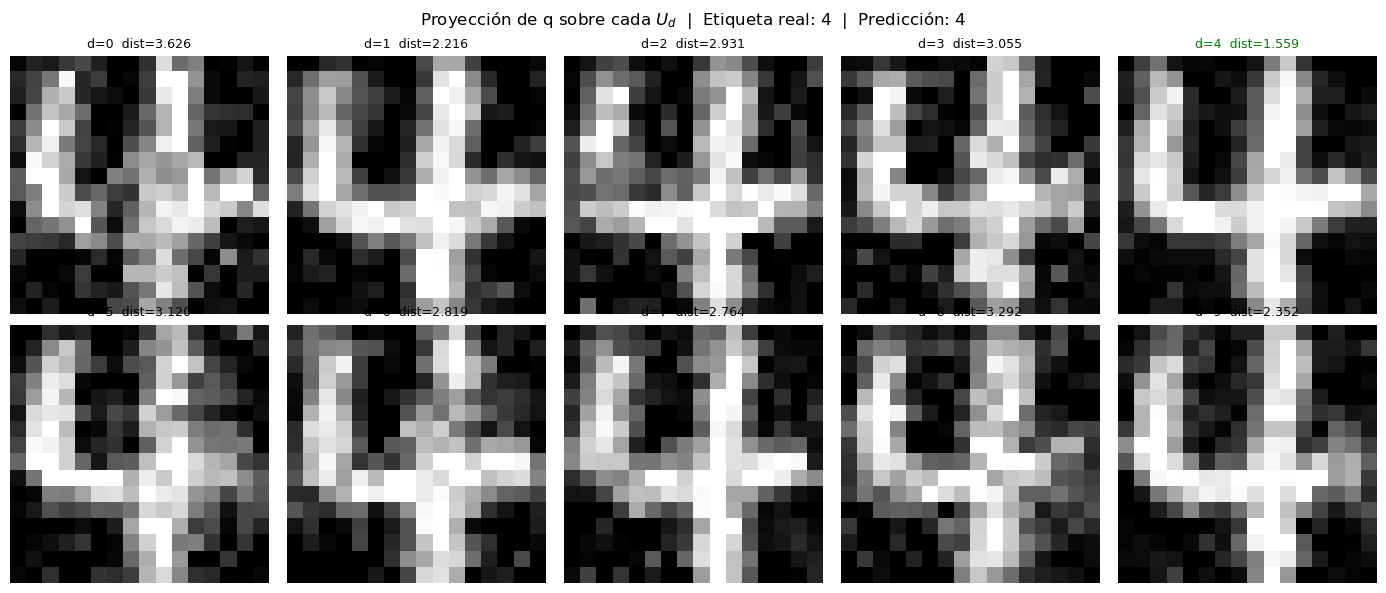

In [ ]:
sample_idx = np.random.choice(len(X_test_raw))
q_sample   = crop_and_resize(X_test_raw[sample_idx]).flatten()
true_label = y_test_raw[sample_idx]

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
distances = {}

for d in range(10):
    B    = bases_best[d]
    p    = project_onto_subspace(q_sample, B)
    dist = np.linalg.norm(q_sample - p)
    distances[d] = dist

    ax = axes[d // 5, d % 5]
    ax.imshow(p.reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'd={d}  dist={dist:.3f}', fontsize=9,
                 color='green' if d == true_label else 'black')
    ax.axis('off')

predicted = min(distances, key=distances.get)
plt.suptitle(
    f'Proyección de q sobre cada $U_d$  |  '
    f'Etiqueta real: {true_label}  |  Predicción: {predicted}',
    fontsize=12
)
plt.tight_layout()
plt.show()

## 5. Reflexión sobre el compromiso $k$ vs. precisión

| $k$ | Comportamiento |
|-----|----------------|
| Pequeño (< 10) | Base $B_d$ con bajo rango → cubre poca variabilidad → muchos errores |
| Medio (≈ 50–200) | Base captura variabilidad principal → accuracy sube rápido |
| Grande (> 200) | El rango efectivo de $M_d$ satura; beneficio marginal decrece |

**¿Por qué la curva se aplana?**  
La dimensión intrínseca de la variabilidad del dígito es mucho menor que 256. Una vez capturadas las direcciones más representativas via SVD, los vectores singulares adicionales corresponden a ruido o variaciones menores que no mejoran la discriminación.

## 6. Ventajas e inconvenientes del método

### Ventajas
- **Interpretabilidad:** cada vector de $B_d$ es una "dirección de variación" del dígito, con significado geométrico claro.
- **Sin optimización iterativa:** no hay descenso de gradiente, solo una SVD por dígito.
- **Inferencia rápida:** clasificar $q$ cuesta $\mathcal{O}(256 \times r)$ por dígito.

### Inconvenientes
- **Linealidad:** los subespacios son lineales; la variabilidad real (rotaciones, deformaciones) es no lineal.
- **Ignora estructura espacial:** trata la imagen como vector sin vecindad de píxeles (a diferencia de las CNNs).
- **Precisión inferior a métodos modernos:** CNNs alcanzan >99% en MNIST; este método ronda 85–93%.

### Comparación con otros enfoques

| Método | Accuracy MNIST | Complejidad | Interpretabilidad |
|--------|---------------|-------------|-------------------|
| **Subespacio ortogonal (este)** | ~85–93% | Baja (SVD) | Alta |
| k-NN en píxeles | ~97% | Baja | Media |
| SVM con RBF | ~98.5% | Media | Baja |
| CNN simple | >99% | Alta | Muy baja |
| Transformer / ViT | >99.5% | Muy alta | Muy baja |

# Ejercicio 3

In [ ]:
# Instalación de librerías
!pip install sentence-transformers
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

# Prueba Psicotécnica de Razonamiento Verbal  
### Contexto Banca Multinacional  

---

## 1. Descripción General

La siguiente prueba corresponde a un conjunto de preguntas de razonamiento verbal diseñadas con un nivel de exigencia similar al utilizado en procesos de selección de entidades financieras multinacionales.

Los ítems evalúan:

- Relaciones conceptuales abstractas  
- Comprensión semántica profunda  
- Asociación funcional y causal  
- Identificación de inconsistencias contextuales  

La prueba se divide en dos secciones:

- **Sección A:** Analogías verbales  
- **Sección B:** Detección de elemento fuera de contexto  

---

# Sección de Analogías (Preguntas)

Cada pregunta sigue la estructura:

> A es a B como C es a ___

Se debe seleccionar la opción que complete correctamente la relación lógica.

---

### 1
**Liquidez es a solvencia como corto plazo es a:**

a) inmediato  
b) riesgo  
c) largo plazo  
d) crédito  

**Respuesta correcta:** largo plazo  

---

### 2
**Auditor es a control como estratega es a:**

a) decisión  
b) planificación  
c) liderazgo  
d) empresa  

**Respuesta correcta:** planificación  

---

### 3
**Inflación es a precios como desempleo es a:**

a) economía  
b) salarios  
c) trabajo  
d) crisis  

**Respuesta correcta:** trabajo  

---

### 4
**Diversificación es a riesgo como capacitación es a:**

a) experiencia  
b) productividad  
c) desempeño  
d) competencia  

**Respuesta correcta:** competencia  

---

### 5
**Activo es a ingreso como pasivo es a:**

a) gasto  
b) deuda  
c) balance  
d) capital  

**Respuesta correcta:** gasto  

---

### 6
**Norma es a cumplimiento como meta es a:**

a) objetivo  
b) logro  
c) planificación  
d) evaluación  

**Respuesta correcta:** logro  

---

### 7
**Ética es a confianza como transparencia es a:**

a) reputación  
b) control  
c) regulación  
d) informe  

**Respuesta correcta:** reputación  

---

### 8
**Oferta es a demanda como escasez es a:**

a) abundancia  
b) precio  
c) mercado  
d) consumo  

**Respuesta correcta:** abundancia  

---

### 9
**Eficiencia es a recursos como eficacia es a:**

a) resultados  
b) metas  
c) costos  
d) estrategia  

**Respuesta correcta:** resultados  

---

### 10
**Riesgo es a incertidumbre como rendimiento es a:**

a) inversión  
b) ganancia  
c) retorno  
d) capital  

**Respuesta correcta:** retorno  

---

# Sección de Detección de Elemento Fuera de Contexto

En cada conjunto de palabras, se debe identificar el término que no pertenece al mismo campo semántico o categoría conceptual.

---

### 1  
{rentabilidad, liquidez, solvencia, montaña}  
**Respuesta correcta:** montaña  

---

### 2  
{auditoría, cumplimiento, regulación, bicicleta}  
**Respuesta correcta:** bicicleta  

---

### 3  
{activo, pasivo, patrimonio, honestidad}  
**Respuesta correcta:** honestidad  

---

### 4  
{inflación, deflación, estanflación, escritorio}  
**Respuesta correcta:** escritorio  

---

### 5  
{liderazgo, motivación, supervisión, semáforo}  
**Respuesta correcta:** semáforo  

---

### 6  
{planificación, ejecución, control, manzana}  
**Respuesta correcta:** manzana  

---

### 7  
{riesgo, volatilidad, incertidumbre, armonía}  
**Respuesta correcta:** armonía  

---

### 8  
{mercado, competencia, monopolio, felicidad}  
**Respuesta correcta:** felicidad  

---

### 9  
{balance, estado de resultados, flujo de caja, océano}  
**Respuesta correcta:** océano  

---

### 10  
{eficiencia, eficacia, productividad, triángulo}  
**Respuesta correcta:** triángulo  


In [6]:
analogias = [
    ("liquidez", "solvencia", "corto plazo",
     ["inmediato", "riesgo", "largo plazo", "crédito"],
     "largo plazo"),

    ("auditor", "control", "estratega",
     ["decisión", "planificación", "liderazgo", "empresa"],
     "planificación"),

    ("inflación", "precios", "desempleo",
     ["economía", "salarios", "trabajo", "crisis"],
     "trabajo"),

    ("diversificación", "riesgo", "capacitación",
     ["experiencia", "productividad", "desempeño", "competencia"],
     "competencia"),

    ("activo", "ingreso", "pasivo",
     ["gasto", "deuda", "balance", "capital"],
     "gasto"),

    ("norma", "cumplimiento", "meta",
     ["objetivo", "logro", "planificación", "evaluación"],
     "logro"),

    ("ética", "confianza", "transparencia",
     ["reputación", "control", "regulación", "informe"],
     "reputación"),

    ("oferta", "demanda", "escasez",
     ["abundancia", "precio", "mercado", "consumo"],
     "abundancia"),

    ("eficiencia", "recursos", "eficacia",
     ["resultados", "metas", "costos", "estrategia"],
     "resultados"),

    ("riesgo", "incertidumbre", "rendimiento",
     ["inversión", "ganancia", "retorno", "capital"],
     "retorno"),
]


contexto = [
    (["rentabilidad", "liquidez", "solvencia", "montaña"], "montaña"),
    (["auditoría", "cumplimiento", "regulación", "bicicleta"], "bicicleta"),
    (["activo", "pasivo", "patrimonio", "honestidad"], "honestidad"),
    (["inflación", "deflación", "estanflación", "escritorio"], "escritorio"),
    (["liderazgo", "motivación", "supervisión", "semáforo"], "semáforo"),
    (["planificación", "ejecución", "control", "manzana"], "manzana"),
    (["riesgo", "volatilidad", "incertidumbre", "armonía"], "armonía"),
    (["mercado", "competencia", "monopolio", "felicidad"], "felicidad"),
    (["balance", "estado de resultados", "flujo de caja", "océano"], "océano"),
    (["eficiencia", "eficacia", "productividad", "triángulo"], "triángulo"),
]

In [ ]:
# Cargar modelo preentrenado
model = SentenceTransformer("all-MiniLM-L6-v2")

In [8]:
def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]

In [9]:
def resolver_analogias_sbert(analogias):
    correctas = 0

    for A, B, C, opciones, respuesta in analogias:

        vecA = model.encode(A)
        vecB = model.encode(B)
        vecC = model.encode(C)

        resultado = vecB - vecA + vecC

        similitudes = []
        for opcion in opciones:
            vecO = model.encode(opcion)
            sim = cosine_sim(resultado, vecO)
            similitudes.append(sim)

        prediccion = opciones[np.argmax(similitudes)]

        if prediccion == respuesta:
            correctas += 1

    return correctas / len(analogias)

In [10]:
def resolver_analogias_tfidf(analogias):

    todas_palabras = []
    for A, B, C, opciones, _ in analogias:
        todas_palabras.extend([A, B, C] + opciones)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(todas_palabras)

    correctas = 0

    for A, B, C, opciones, respuesta in analogias:

        vecA = vectorizer.transform([A]).toarray()[0]
        vecB = vectorizer.transform([B]).toarray()[0]
        vecC = vectorizer.transform([C]).toarray()[0]

        resultado = vecB - vecA + vecC

        similitudes = []
        for opcion in opciones:
            vecO = vectorizer.transform([opcion]).toarray()[0]
            sim = cosine_sim(resultado, vecO)
            similitudes.append(sim)

        prediccion = opciones[np.argmax(similitudes)]

        if prediccion == respuesta:
            correctas += 1

    return correctas / len(analogias)

In [11]:
def resolver_contexto_tfidf(contexto):

    todas_palabras = []
    for palabras, _ in contexto:
        todas_palabras.extend(palabras)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(todas_palabras)

    correctas = 0

    for palabras, respuesta in contexto:

        embeddings = vectorizer.transform(palabras).toarray()
        centroide = np.mean(embeddings, axis=0)

        similitudes = [cosine_sim(e, centroide) for e in embeddings]
        prediccion = palabras[np.argmin(similitudes)]

        if prediccion == respuesta:
            correctas += 1

    return correctas / len(contexto)

In [12]:
def resolver_contexto_sbert(contexto):
    correctas = 0

    for palabras, respuesta in contexto:

        embeddings = model.encode(palabras)
        centroide = np.mean(embeddings, axis=0)

        similitudes = [cosine_sim(e, centroide) for e in embeddings]
        prediccion = palabras[np.argmin(similitudes)]

        if prediccion == respuesta:
            correctas += 1

    return correctas / len(contexto)

In [13]:
resultados = {
    "Analogías SBERT": resolver_analogias_sbert(analogias),
    "Analogías TF-IDF": resolver_analogias_tfidf(analogias),
    "Contexto SBERT": resolver_contexto_sbert(contexto),
    "Contexto TF-IDF": resolver_contexto_tfidf(contexto),
}

resultados

{'Analogías SBERT': 0.2,
 'Analogías TF-IDF': 0.5,
 'Contexto SBERT': 0.5,
 'Contexto TF-IDF': 0.0}

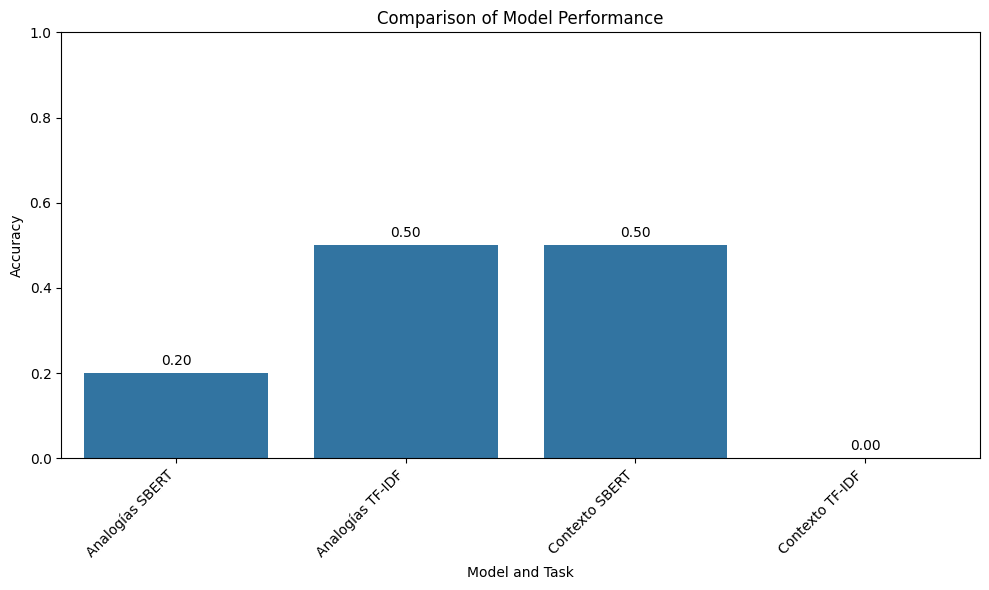

In [14]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=list(resultados.keys()), y=list(resultados.values()))

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.title("Comparison of Model Performance")
plt.ylabel("Accuracy")
plt.xlabel("Model and Task")
plt.tight_layout()
plt.show()

Para visualizar la relación A-B+C=D en una analogía, se selecciona una analogía, codificando sus componentes (A, B, C y el D correcto) utilizando SBERT, se calcula el vector resultante (B - A + C), se combina todos los vectores relevantes y luego se aplica PCA para reducir su dimensionalidad y representarlos en un gráfico 2D, anotando cada punto para mayor claridad.

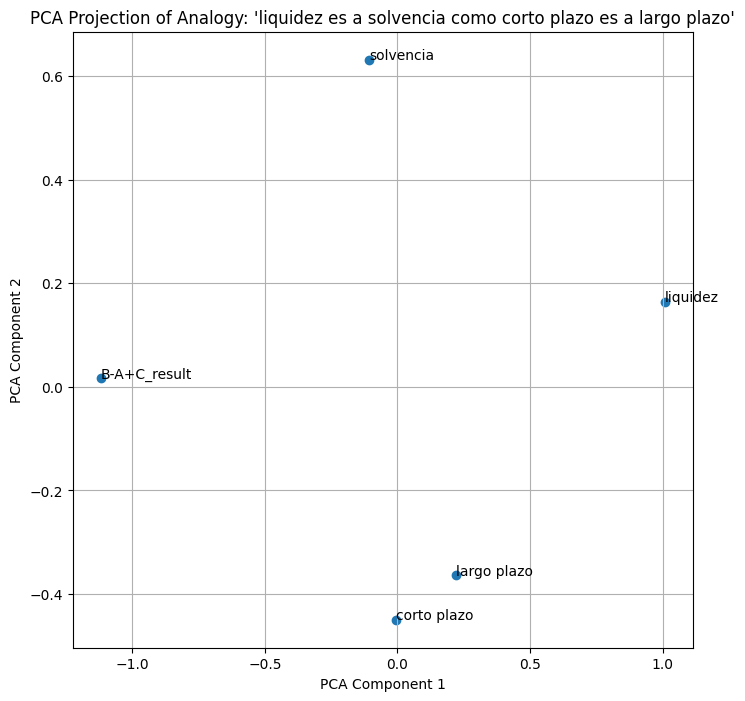

In [15]:
analogy_example = analogias[0] # Obtener la primera analogia
A, B, C, opciones, D_correct = analogy_example

# Encode palabras utilizando SBERT
vecA = model.encode(A)
vecB = model.encode(B)
vecC = model.encode(C)
vecD_correct = model.encode(D_correct)

# Calcular el vector resultante por analogía (B - A + C)
resultant_vector = vecB - vecA + vecC

# Combinar todos los vectores por PCA visualization
# A, B, C, D_correct, y el vector resultante
palabras_analogy_pca = [A, B, C, D_correct, "B-A+C_result"]
embeddings_analogy_pca = np.array([vecA, vecB, vecC, vecD_correct, resultant_vector])

# Aplicar PCA
pca_analogy = PCA(n_components=2)
reducido_analogy = pca_analogy.fit_transform(embeddings_analogy_pca)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(reducido_analogy[:, 0], reducido_analogy[:, 1])

for i, txt in enumerate(palabras_analogy_pca):
    plt.annotate(txt, (reducido_analogy[i, 0], reducido_analogy[i, 1]))

plt.title(f"PCA Projection of Analogy: '{A} es a {B} como {C} es a {D_correct}'")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


Ahora para visualizar el valor atípico en una pregunta de contexto, se selecciona una pregunta, se codifica todas sus palabras utilizando SBERT, aplica PCA para reducir su dimensionalidad y las grafica, resaltando claramente la palabra atípica que fue identificada previamente.

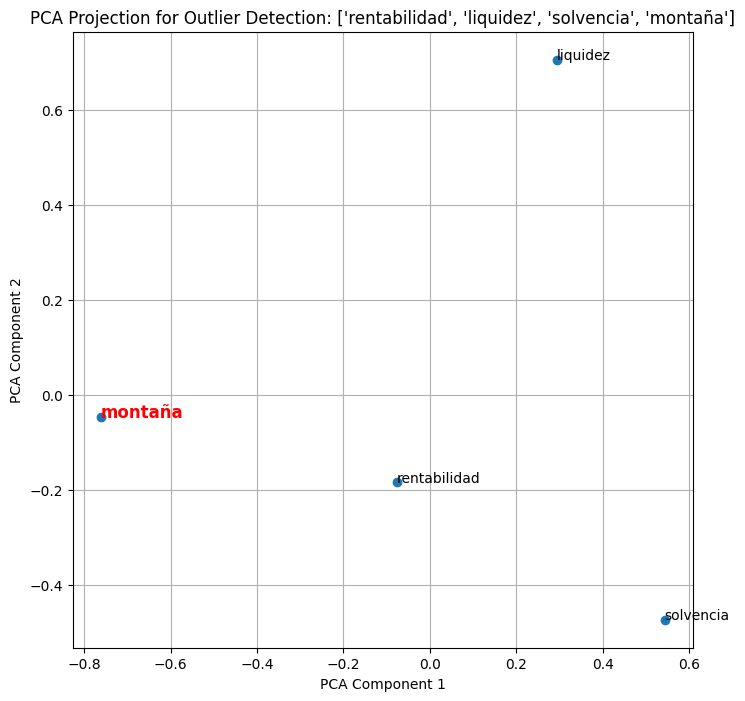

In [16]:
context_example = contexto[0] # Obtener la primera pregunta de contexto
palabras_contexto, outlier_correct = context_example

# Encode palabras usando SBERT
embeddings_contexto = model.encode(palabras_contexto)

# Aplicando PCA
pca_contexto = PCA(n_components=2)
reducido_contexto = pca_contexto.fit_transform(embeddings_contexto)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(reducido_contexto[:, 0], reducido_contexto[:, 1])

for i, txt in enumerate(palabras_contexto):
    if txt == outlier_correct:
        plt.annotate(txt, (reducido_contexto[i, 0], reducido_contexto[i, 1]), color='red', fontsize=12, fontweight='bold')
    else:
        plt.annotate(txt, (reducido_contexto[i, 0], reducido_contexto[i, 1]))

plt.title(f"PCA Projection for Outlier Detection: {palabras_contexto}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

## Conclusiones de la Actividad

**Comparación del rendimiento del modelo (Gráfico de Barras):**

*   **Analogías:** El modelo TF-IDF (0.50 de precisión) superó al modelo SBERT (0.20 de precisión) en la resolución de analogías. Esto sugiere que para las relaciones analógicas específicas en este conjunto de datos, la representación dispersa y la ponderación de palabras de TF-IDF capturaron mejor las similitudes que las incrustaciones densas de SBERT.
*   **Detección de elementos fuera de contexto:** El modelo SBERT (0.50 de precisión) mostró un rendimiento significativamente mejor que el modelo TF-IDF (0.00 de precisión) en la detección de palabras fuera de contexto. Esto indica que la capacidad de SBERT para capturar el significado semántico y las relaciones contextuales es crucial para esta tarea, mientras que TF-IDF tuvo dificultades para identificar el elemento atípico.

**Visualización PCA (Analogías):**

*   La gráfica de PCA para la analogía "Liquidez es a solvencia como corto plazo es a largo plazo" muestra la relación espacial entre las palabras y el vector resultante `B-A+C`. Idealmente, el punto `B-A+C_result` debería estar muy cerca del punto `largo plazo`. La proximidad visual en el gráfico indica qué tan bien el modelo SBERT captura la relación analógica en su espacio de incrustación.

**Visualización PCA (Detección de Elementos Fuera de Contexto):**

*   La gráfica de PCA para la detección de elementos fuera de contexto, utilizando el ejemplo "rentabilidad, liquidez, solvencia, montaña", ilustra cómo el modelo SBERT agrupa semánticamente las palabras. Se espera que las palabras relacionadas con las finanzas (rentabilidad, liquidez, solvencia) formen un clúster, mientras que la palabra atípica (montaña) se encuentre significativamente alejada de este grupo, lo que facilita su identificación como el elemento discordante. El color rojo de 'montaña' resalta visualmente su separación del grupo principal.